In [1]:
# Import packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.stats.multitest as smm
from pathlib import Path
from matplotlib.ticker import FixedFormatter, FixedLocator

# 1 Import Data

In [2]:
# Import DEG data 
deg_na = pd.read_csv('11_identify_DEG/deg_na.csv')
deg_nr = pd.read_csv('11_identify_DEG/deg_nr.csv')
deg_ar = pd.read_csv('11_identify_DEG/deg_ar.csv')

# Import DEG NA up and down for seperated GO enrichment analysis
deg_na_up = pd.read_csv('11_identify_DEG/deg_na_up.csv')
deg_na_down = pd.read_csv('11_identify_DEG/deg_na_down.csv')

deg={'deg_na': deg_na, 'deg_nr': deg_nr, 'deg_ar': deg_ar, 'deg_na_up': deg_na_up, 'deg_na_down': deg_na_down}

# Import GO data 
# Geneid to GO term
goterm = pd.read_csv('14_functional_annotation/ccar2swissprotGO_long.txt', sep='\t') 
# rename columns
goterm.columns = ['gene_id', 'id']
# GO term to description
godesc = pd.read_csv('14_functional_annotation/go_data.txt', sep='\t')
godesc.set_index('id', inplace=True)


# 2 Match GO term to gene id before GO enrichment analysis 

In [3]:
# filter for genes in correlation data for the goterm df 
gotermNA = goterm[goterm['gene_id'].isin(deg_na['Unnamed: 0'])]
gotermNR = goterm[goterm['gene_id'].isin(deg_nr['Unnamed: 0'])]
gotermAR = goterm[goterm['gene_id'].isin(deg_ar['Unnamed: 0'])]

# filter the genes in correlation data for the goterm df 
gotermNAup = goterm[goterm['gene_id'].isin(deg_na_up['Unnamed: 0'])]
gotermNAdown = goterm[goterm['gene_id'].isin(deg_na_down['Unnamed: 0'])]


#print(gotermNA)
#print(gotermNR)
#print(gotermAR)


In [4]:

# merge goterm and godesc on goterm
gotermNA = pd.merge(gotermNA, godesc, on='id')
gotermNR = pd.merge(gotermNR, godesc, on='id')
gotermAR = pd.merge(gotermAR, godesc, on='id')

# merge goterm and godesc on goterm
gotermNAup = pd.merge(gotermNAup, godesc, on='id')
gotermNAdown = pd.merge(gotermNAdown, godesc, on='id')


# 3 GO go_na Analysis Output 

In [5]:
go_files = sorted(Path("14_functional_annotation").glob('deg_*_GOterms.csv'))

# total number of genes in the background dataset 
total_num_genes = pd.read_csv('12_gene_length_distribution/total_number_of_genes.csv', sep=',')

# create empty dict for df's
go_enriched = []


for f in go_files: 
    go_terms = pd.read_csv(f, sep=',')
    # strip emtpy space around GO terms 
    go_terms['category'] = go_terms['category'].str.strip()
    # since the term and ontology column are empty, I filled them with information from the godesc dataframe
    go_terms['term'] = godesc.loc[go_terms['category'], 'name'].to_numpy()
    go_terms['ontology'] = godesc.loc[go_terms['category'], 'namespace'].to_numpy()
    # calculate expected number in each category 
    go_terms['expectedDEInCat'] = (go_terms['numInCat']/len(total_num_genes))*len(deg[f.stem[:-8]])
    # calculate fold enrichment
    go_terms['foldEnrichment'] = (go_terms['numDEInCat']/go_terms['expectedDEInCat'])
    # calculate negative fold change from the FDR corrected values
    #go_terms['-log10(FDR)'] = -np.log10(go_terms['over_represented_pvalue'])
    go_terms['padj'] = smm.multipletests(go_terms['over_represented_pvalue'], method='bonferroni')[1]
    go_terms['-log10(padj)'] = -np.log10(go_terms['padj'])
    go_terms = go_terms.sort_values(by='padj')
    go_terms = go_terms.loc[go_terms['padj'] <= 0.05]#.iloc[-10:]
    if 'deg_na_up' in f.name:
        go_terms['comparison'] = 'Normoxia to Anoxia Upregulated'
    elif 'deg_na_down' in f.name:
        go_terms['comparison'] = 'Normoxia to Anoxia Downregulated'
    elif 'deg_na' in f.name: 
        go_terms['comparison'] = 'Normoxia to Anoxia'
    elif 'deg_nr' in f.name:
        go_terms['comparison'] = 'Normoxia to Reoxygenation'
    elif 'deg_ar' in f.name:
        go_terms['comparison'] = 'Anoxia to Reoxygenation'
    # save to list 
    go_enriched.append(go_terms)
# merge the dataframes and add column with name of comparison
go = pd.concat(go_enriched, ignore_index=True)
go['log2(foldEnrichment)'] = np.log2(go['foldEnrichment'])
go.sort_values(by='log2(foldEnrichment)', ascending=False, inplace=True)


In [6]:
go['comparison'].unique()


array(['Anoxia to Reoxygenation', 'Normoxia to Reoxygenation',
       'Normoxia to Anoxia Downregulated',
       'Normoxia to Anoxia Upregulated', 'Normoxia to Anoxia'],
      dtype=object)

In [7]:
go_enriched[1]


,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,expectedDEInCat,foldEnrichment,padj,-log10(padj),comparison
1,GO:0055091,4.793663e-09,1.0,10,30,phospholipid homeostasis,BP,0.831016,12.033465,0.000092,4.037731,Normoxia to Anoxia
2,GO:0031418,9.744109e-09,1.0,11,40,L-ascorbic acid binding,MF,1.108021,9.927609,0.000186,3.729656,Normoxia to Anoxia
3,GO:0031545,1.429482e-08,1.0,6,8,peptidyl-proline 4-dioxygenase activity,MF,0.221604,27.075296,0.000273,3.563220,Normoxia to Anoxia
4,GO:0005634,3.325560e-08,1.0,349,9806,nucleus,CC,271.631375,1.284829,0.000636,3.196534,Normoxia to Anoxia
5,GO:0160082,2.147268e-07,1.0,6,11,hypoxia-inducible factor-proline dioxygenase a...,MF,0.304706,19.691125,0.004107,2.386512,Normoxia to Anoxia
6,GO:0006631,2.624235e-07,1.0,18,151,fatty acid metabolic process,BP,4.182780,4.303358,0.005019,2.299396,Normoxia to Anoxia
7,GO:0045766,4.878348e-07,1.0,26,304,positive regulation of angiogenesis,BP,8.420960,3.087534,0.009330,2.030126,Normoxia to Anoxia
8,GO:0016706,1.605233e-06,1.0,8,31,2-oxoglutarate-dependent dioxygenase activity,MF,0.858716,9.316231,0.030700,1.512860,Normoxia to Anoxia
9,GO:0015432,1.779486e-06,1.0,5,9,ABC-type bile acid transporter activity,MF,0.249305,20.055775,0.034033,1.468104,Normoxia to Anoxia


In [8]:
# Identification of redundant GO terms 
# export GO terms and padj values as import to Revigo
for comparison, data in go.groupby('comparison'):
    regivo = data[['category', 'padj']]
    regivo.to_csv(f'14_functional_annotation/1_for_regivo_input/go_{comparison}_to_revigo.csv', index=False, sep='\t')



In [9]:
# Output from Regivo
# Since I get three files for each comparison, I will merge them into one file
base_dir = Path('14_functional_annotation/2_regivo_output')

dfs = []

for subdir in base_dir.iterdir():
    if not subdir.is_dir():
        continue
    go_files = sorted(subdir.glob('Revigo_*_OnScreenTable.tsv'))
    for f in go_files:
        df = pd.read_csv(f, sep='\t')
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True)
    # Define the output file path
    output_file = subdir / f"{subdir.name}_non_redundant_go_terms.csv"
    # Save the concatenated DataFrame to the output file
    concatenated_df.to_csv(output_file, index=False)

non_red_go = {'Normoxia to Anoxia': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/NvsA/NvsA_non_redundant_go_terms.csv'),
              'Normoxia to Reoxygenation': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/NvsR/NvsR_non_redundant_go_terms.csv'), 
              'Anoxia to Reoxygenation': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/AvsR/AvsR_non_redundant_go_terms.csv'),
              'Normoxia to Anoxia Upregulated': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/NvsAup/NvsAup_non_redundant_go_terms.csv'),
              'Normoxia to Anoxia Downregulated': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/NvsAdown/NvsAdown_non_redundant_go_terms.csv')}

non_red = []

# Filter the go dataframe to only include the non-redundant GO terms
for comparison, data in go.groupby('comparison'):
    non_red.append(go.loc[go['category'].isin(non_red_go[comparison]['TermID'])])
go = pd.concat(non_red)



In [10]:
# split go into up and downregulated genes and comparisond 
go_updown = go.loc[(go['comparison'].str.contains('Upregulated')) | (go['comparison'].str.contains('Downregulated'))]
go_comparison = go.loc[~(go['comparison'].str.contains('Upregulated')) & ~(go['comparison'].str.contains('Downregulated'))]

<Axes: xlabel='ontology', ylabel='Count'>

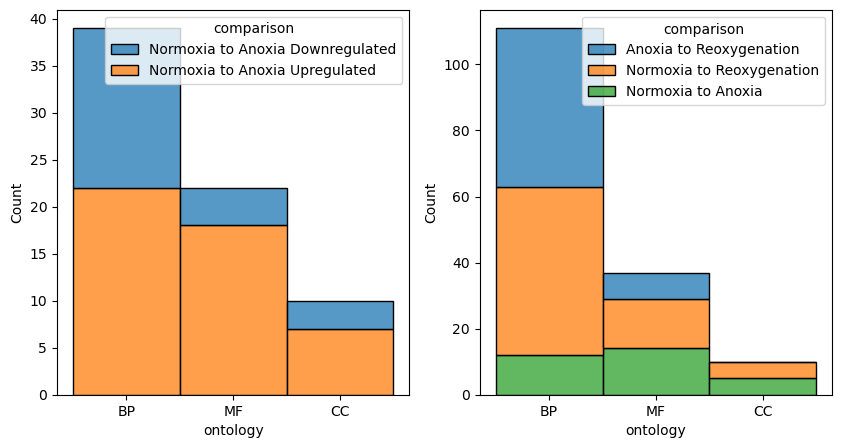

In [11]:
fig,axes = plt.subplots(1,2,figsize=(10, 5))
sns.histplot(data=go_updown, x='ontology', hue='comparison', bins=10, multiple='stack', ax=axes[0])
sns.histplot(data=go_comparison, x='ontology', hue='comparison', bins=10, multiple='stack', ax=axes[1])

In [12]:
# fo through go and keep only the top ten for each ontology 
go_for_plot=[]

for (ontology,comparison), data in go_comparison.groupby(['ontology', 'comparison']):
    temp = data.sort_values(by=['log2(foldEnrichment)', '-log10(padj)'], ascending=[False, True]).iloc[:30]
    go_for_plot.append(temp)
go_plot = pd.concat(go_for_plot)


# 4.1 Plot

/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


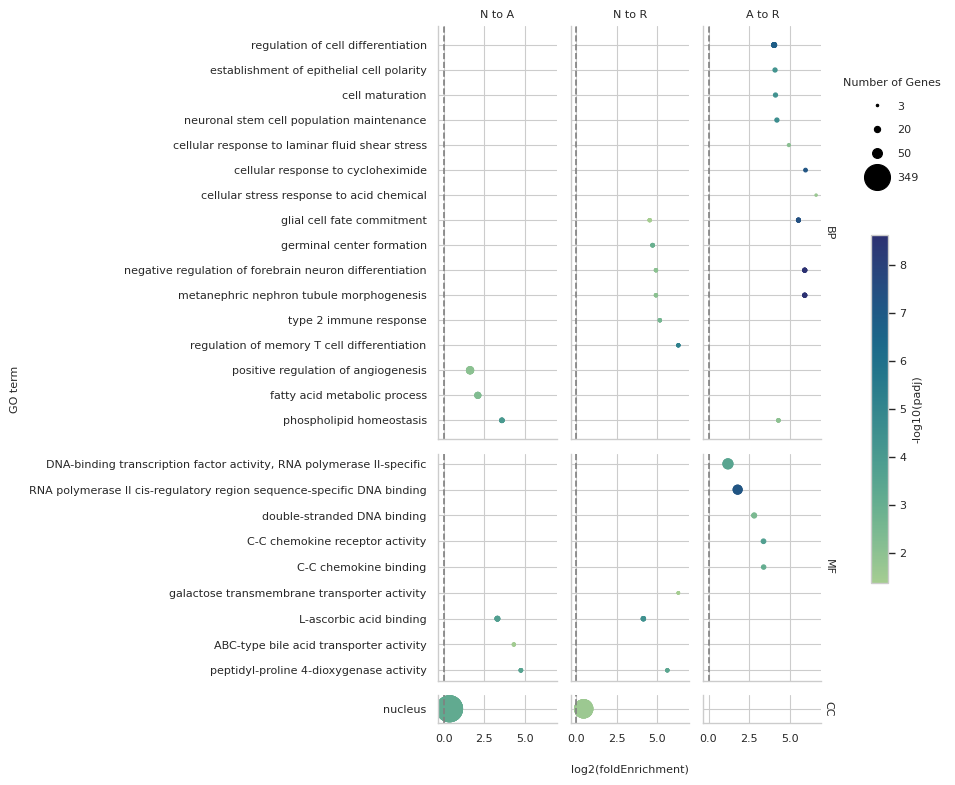

In [137]:
# define a function to acces the df in arrays 
def custum_scatterplot(data, norm, cmap, **kwargs):
    scatter = plt.scatter(x=data['log2(foldEnrichment)'], y=data['term'], c=data['-log10(padj)'], s=data["numDEInCat"], norm=norm, cmap=cmap)
    h, l = scatter.legend_elements(prop='sizes', num=FixedLocator([int(go_plot['numDEInCat'].min()),20, 50,int(go_plot['numDEInCat'].max())], nbins=5))
    handles.extend(h)
    labels.extend(l)
# needed for legend number of Genes 
handles, labels = [], []

# create color bar
norm = plt.Normalize(go_plot['-log10(padj)'].min(), go_plot['-log10(padj)'].max())
cmap = sns.color_palette(palette='crest', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# create a Facetgrid 3x3
sns.set_theme(palette = 'crest', style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
g = sns.FacetGrid(go_plot, col='comparison', row ='ontology', sharey='row', sharex = True, gridspec_kws={'height_ratios':[3,1.65,0.2]}, 
                  col_order=['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation'], row_order= ['BP', 'MF', 'CC' ], margin_titles=True)

# set size for fig 
g.figure.set_figwidth(25/2.54)
g.figure.set_figheight(20/2.54)
g.map_dataframe(custum_scatterplot, norm=norm, cmap=cmap)

# set title 
g.set_titles(template= '', col_template='', row_template='{row_name}')   
g.figure.supxlabel('log2(foldEnrichment)', x=0.65, fontsize=8)
g.figure.supylabel('GO term', fontsize=8)
g.axes_dict[('BP', 'Anoxia to Reoxygenation')].set_title('A to R', fontsize=8)
g.axes_dict[('BP', 'Normoxia to Reoxygenation')].set_title('N to R', fontsize=8)
g.axes_dict[('BP', 'Normoxia to Anoxia')].set_title('N to A', fontsize=8)
g.refline(x=0)


# legend NUmber of Genes 
han = pd.Series(handles, index=labels)
han = han.loc[~han.index.duplicated(keep='first')]
han.index = han.index.str.replace('$\mathdefault{', '')
han.index = han.index.str.replace('}$', '')
han.index = han.index.astype(int)
han = han.sort_index(ascending=True)

legend = g.axes[0,2].legend(han.values, han.index, loc="upper left", title="Number of Genes", bbox_to_anchor=(1.1, 0.9), frameon=False, labelspacing=1.25, fontsize=8)

# add color bar 
plt.colorbar(sm, label='-log10(padj)', use_gridspec=True, ax=g.axes, location='right', shrink=0.5, pad=-0.17, anchor=(0,0.4))

g.tight_layout()



# plot for paper 

/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


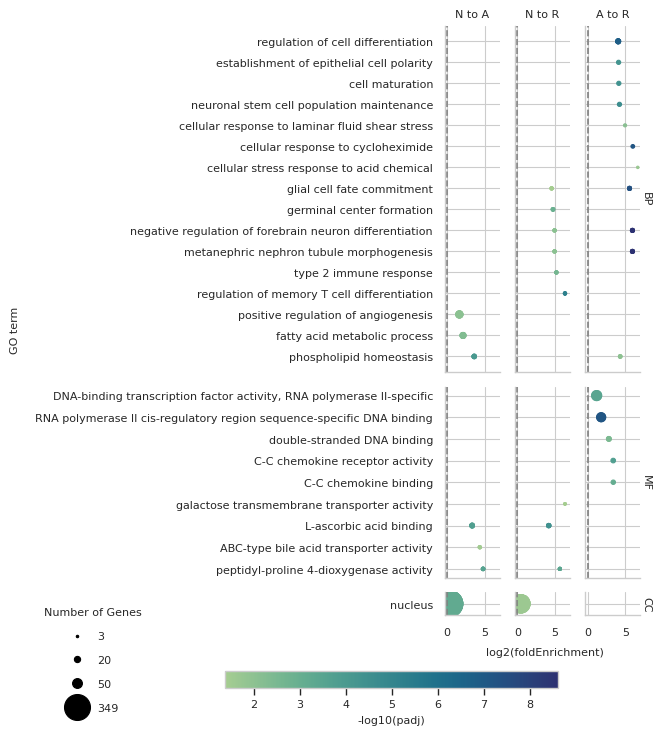

In [109]:
# define a function to acces the df in arrays 
def custum_scatterplot(data, norm, cmap, **kwargs):
    scatter = plt.scatter(x=data['log2(foldEnrichment)'], y=data['term'], c=data['-log10(padj)'], s=data["numDEInCat"], norm=norm, cmap=cmap)
    h, l = scatter.legend_elements(prop='sizes', num=FixedLocator([int(go_plot['numDEInCat'].min()),20, 50,int(go_plot['numDEInCat'].max())], nbins=5))
    handles.extend(h)
    labels.extend(l)
# needed for legend number of Genes 
handles, labels = [], []

# create color bar
norm = plt.Normalize(go_plot['-log10(padj)'].min(), go_plot['-log10(padj)'].max())
cmap = sns.color_palette(palette='crest', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# create a Facetgrid 3x3
sns.set_theme(palette = 'crest', style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
g = sns.FacetGrid(go_plot, col='comparison', row ='ontology', sharey='row', sharex = True, gridspec_kws={'height_ratios':[3,1.65,0.2]}, 
                  col_order=['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation'], row_order= ['BP', 'MF', 'CC' ], margin_titles=True)

# set size for fig 
g.figure.set_figwidth(17/2.54)
g.figure.set_figheight(17/2.54)
g.map_dataframe(custum_scatterplot, norm=norm, cmap=cmap)

# set title 
g.set_titles(template= '', col_template='', row_template='{row_name}')   
g.figure.supxlabel('log2(foldEnrichment)', x=0.82, fontsize=8)
g.figure.supylabel('GO term', fontsize=8)
g.axes_dict[('BP', 'Anoxia to Reoxygenation')].set_title('A to R', fontsize=8)
g.axes_dict[('BP', 'Normoxia to Reoxygenation')].set_title('N to R', fontsize=8)
g.axes_dict[('BP', 'Normoxia to Anoxia')].set_title('N to A', fontsize=8)
g.refline(x=0)


# legend NUmber of Genes 
han = pd.Series(handles, index=labels)
han = han.loc[~han.index.duplicated(keep='first')]
han.index = han.index.str.replace('$\mathdefault{', '')
han.index = han.index.str.replace('}$', '')
han.index = han.index.astype(int)
han = han.sort_index(ascending=True)

legend = g.axes[0,2].legend(han.values, han.index, loc="upper left", title="Number of Genes", bbox_to_anchor=(-10, -0.65), frameon=False, labelspacing=1.25, fontsize=8)

# add color bar 
plt.colorbar(sm, label='-log10(padj)', use_gridspec=False, ax=g.axes, location='bottom', shrink=1.7, pad=-0.17, anchor=(1.6,-1.2))

g.tight_layout()
g.savefig('14_functional_annotation/GO_enrichment_analyis.svg')


# 4.2 PLOT NvsA up / down

In [110]:
# fo through go and keep only the top ten for each ontology 
go_for_plot=[]

for (ontology,comparison), data in go_updown.groupby(['ontology', 'comparison']):
    temp = data.sort_values(by=['log2(foldEnrichment)', '-log10(padj)'], ascending=[False, True]).iloc[:30]
    go_for_plot.append(temp)
go_plot_updown = pd.concat(go_for_plot)

/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


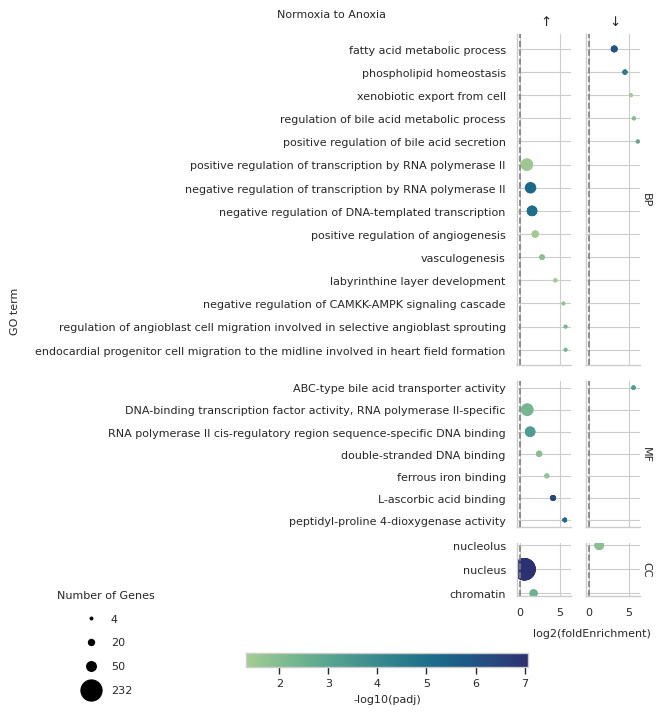

In [136]:
# define a function to acces the df in arrays 
def custum_scatterplot(data, norm, cmap, **kwargs):
    scatter = plt.scatter(x=data['log2(foldEnrichment)'], y=data['term'], c=data['-log10(padj)'], s=data["numDEInCat"], norm=norm, cmap=cmap)
    h, l = scatter.legend_elements(prop='sizes', num=FixedLocator([int(go_plot_updown['numDEInCat'].min()),20, 50,int(go_plot_updown['numDEInCat'].max())], nbins=5))
    handles.extend(h)
    labels.extend(l)
# needed for legend number of Genes 
handles, labels = [], []

# create color bar
norm = plt.Normalize(go_plot_updown['-log10(padj)'].min(), go_plot_updown['-log10(padj)'].max())
cmap = sns.color_palette(palette='crest', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# create a Facetgrid 2x3
sns.set_theme(palette = 'crest', style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
g = sns.FacetGrid(go_plot_updown, col='comparison', row ='ontology', sharey='row', sharex = True, gridspec_kws={'height_ratios':[5,2.2,0.8]}, 
                  col_order=['Normoxia to Anoxia Upregulated', 'Normoxia to Anoxia Downregulated'], row_order= ['BP', 'MF', 'CC' ], margin_titles=True)

# set size for fig 
g.figure.set_figwidth(17/2.54)
g.figure.set_figheight(17/2.54)
g.map_dataframe(custum_scatterplot, norm=norm, cmap=cmap)

# set title 
g.set_titles(template= '', col_template='', row_template='{row_name}')   
g.figure.supxlabel('log2(foldEnrichment)', x= 0.89,fontsize=8)
g.figure. supylabel('GO term', fontsize=8)
g.figure.suptitle('Normoxia to Anoxia', fontsize=8, ha='center', y=0.95)
g.axes_dict[('BP', 'Normoxia to Anoxia Upregulated')].set_title(fr'$\uparrow$')
g.axes_dict[('BP', 'Normoxia to Anoxia Downregulated')].set_title(fr'$\downarrow$')

g.refline(x=0)


# legend NUmber of Genes 
han = pd.Series(handles, index=labels)
han = han.loc[~han.index.duplicated(keep='first')]
han.index = han.index.str.replace('$\mathdefault{', '')
han.index = han.index.str.replace('}$', '')
han.index = han.index.astype(int)
han = han.sort_index(ascending=True)

legend = g.axes[0,1].legend(han.values, han.index, loc="upper left", title="Number of Genes", bbox_to_anchor=(-10, -0.65), frameon=False, labelspacing=1.25, fontsize=8)

# add color bar 
plt.colorbar(sm, label='-log10(padj)', use_gridspec=False, ax=g.axes, location='bottom', shrink=2.3, pad=-0.17, anchor=(1.7,-1.2))

g.tight_layout()
g.savefig('14_functional_annotation/GO_enrichment_analyis_NAupdown.svg')